<a href="https://colab.research.google.com/github/dornercr/INFO371/blob/main/INFO371_Week5_FeatureEngineering_ModelSelection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import random

In [2]:
n_patients = 1316
start_date = datetime(2023, 1, 1)
dates = [start_date + timedelta(days=int(i)) for i in np.random.randint(0, 180, size=n_patients)]
admit_depts = ["Cardiology", "Oncology", "Emergency", "Neurology", "Orthopedics", "General Surgery"]
discharge_depts = np.random.choice(admit_depts, size=n_patients)
age = np.random.randint(18, 90, size=n_patients)
los = np.random.randint(1, 15, size=n_patients)  # Length of stay
readmit = np.random.choice([0, 1], size=n_patients, p=[0.7, 0.3])

df = pd.DataFrame({
    "Discharge Date": dates,
    "Discharge Department": discharge_depts,
    "Age": age,
    "Length of Stay": los,
    "Readmitted": readmit
})

df.head()


,Discharge Date,Discharge Department,Age,Length of Stay,Readmitted
0,2023-04-03,Orthopedics,67,9,0
1,2023-03-19,Neurology,73,12,0
2,2023-02-15,Orthopedics,62,10,0
3,2023-02-03,Orthopedics,62,5,1
4,2023-01-11,Orthopedics,56,1,1


In [3]:
y_readmit = df["Readmitted"].values


In [4]:
from sklearn.preprocessing import OneHotEncoder
onehot = OneHotEncoder()
onehot.fit(df[["Discharge Department"]])
X = onehot.transform(df[["Discharge Department"]]).toarray()


In [5]:
from sklearn.tree import DecisionTreeClassifier
dt_med = DecisionTreeClassifier()
dt_med.fit(X, y_readmit)


DecisionTreeClassifier()

In [6]:
from sklearn.tree import export_text
print(export_text(dt_med, feature_names=onehot.categories_[0]))


|--- General Surgery <= 0.50
|   |--- Cardiology <= 0.50
|   |   |--- Orthopedics <= 0.50
|   |   |   |--- Emergency <= 0.50
|   |   |   |   |--- Oncology <= 0.50
|   |   |   |   |   |--- class: 0
|   |   |   |   |--- Oncology >  0.50
|   |   |   |   |   |--- class: 0
|   |   |   |--- Emergency >  0.50
|   |   |   |   |--- class: 0
|   |   |--- Orthopedics >  0.50
|   |   |   |--- class: 0
|   |--- Cardiology >  0.50
|   |   |--- class: 0
|--- General Surgery >  0.50
|   |--- class: 0



In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y_readmit, test_size=0.2, random_state=42)

dt_med = DecisionTreeClassifier()
dt_med.fit(X_train, y_train)

from sklearn.metrics import accuracy_score
y_pred = dt_med.predict(X_test)
accuracy_score(y_test, y_pred)


0.678030303030303

In [8]:
from sklearn.model_selection import cross_val_score
dt_med = DecisionTreeClassifier()
scores = cross_val_score(dt_med, X, y_readmit, cv=10, scoring='accuracy')
print("The accuracy of predicting readmission from department: {:.2f}".format(np.mean(scores)))


The accuracy of predicting readmission from department: 0.68


In [9]:
df['DeptReadmitLast'] = 0
from collections import defaultdict
dept_last_readmit = defaultdict(int)

for index, row in df.sort_values("Discharge Date").iterrows():
    dept = row['Discharge Department']
    df.at[index, 'DeptReadmitLast'] = dept_last_readmit[dept]
    dept_last_readmit[dept] = row['Readmitted']

X_deptLast = df[['DeptReadmitLast']]
scores = cross_val_score(DecisionTreeClassifier(), X_deptLast, y_readmit, scoring='accuracy')
print("Accuracy with DeptReadmitLast: {:.2f}".format(np.mean(scores)))


Accuracy with DeptReadmitLast: 0.68


In [10]:
name_onehot = pd.get_dummies(df['Discharge Department'])
X_combined = pd.concat([name_onehot, df[['DeptReadmitLast', 'Length of Stay']]], axis=1)

dt_med = DecisionTreeClassifier()
scores = cross_val_score(dt_med, X_combined, y_readmit, scoring='accuracy')
print("Accuracy with names + last readmit + LOS: {:.2f}".format(np.mean(scores)))


Accuracy with names + last readmit + LOS: 0.64


In [11]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=14)
scores = cross_val_score(rf, X_combined, y_readmit, scoring='accuracy')
print("Random Forest Accuracy: {:.2f}".format(np.mean(scores)))


Random Forest Accuracy: 0.62


In [12]:
from sklearn.model_selection import GridSearchCV
param_grid = {
    "max_features": ["sqrt", "log2", None],
    "n_estimators": [100, 200],
    "criterion": ["gini", "entropy"],
    "min_samples_leaf": [2, 4, 6],
}

grid = GridSearchCV(RandomForestClassifier(random_state=14), param_grid)
grid.fit(X_combined, y_readmit)
print("Best Grid Search Accuracy: {:.2f}".format(grid.best_score_))
print(grid.best_estimator_)


Best Grid Search Accuracy: 0.66
RandomForestClassifier(max_features='log2', min_samples_leaf=6,
                       n_estimators=200, random_state=14)


In [13]:
final_model = grid.best_estimator_
y_pred_final = final_model.predict(X_combined)
accuracy_score(y_readmit, y_pred_final)


0.6899696048632219

<function matplotlib.pyplot.ylabel(ylabel: 'str', fontdict: 'dict[str, Any] | None' = None, labelpad: 'float | None' = None, *, loc: "Literal['bottom', 'center', 'top'] | None" = None, **kwargs) -> 'Text'>

<Figure size 1000x600 with 0 Axes>

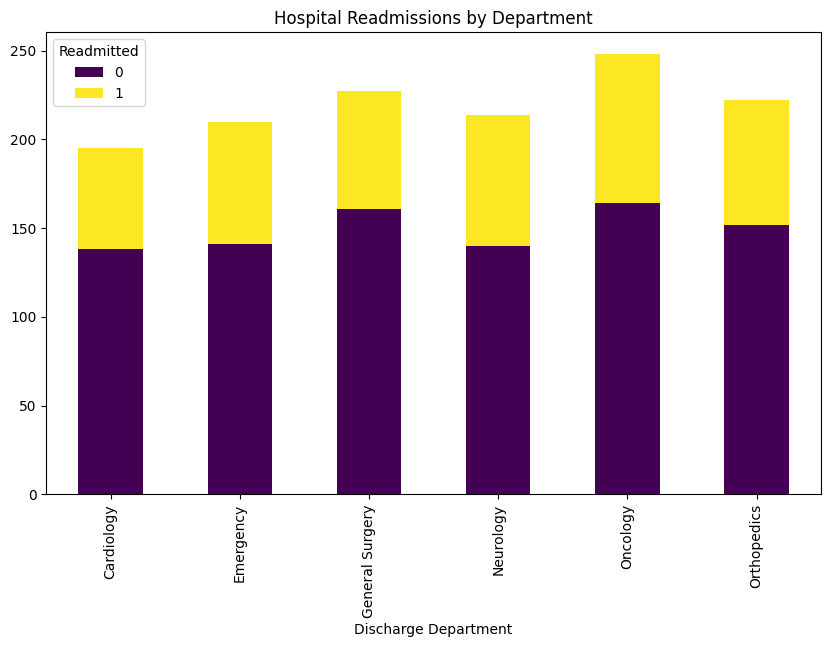

In [15]:
import matplotlib.pyplot as plt
# Plot: Readmission count by department
plt.figure(figsize=(10, 6))
df_grouped = df.groupby(['Discharge Department', 'Readmitted']).size().unstack(fill_value=0)
df_grouped.plot(kind='bar', stacked=True, colormap='viridis', figsize=(10, 6))
plt.title("Hospital Readmissions by Department")
plt.xlabel("Discharge Department")
plt.ylabel

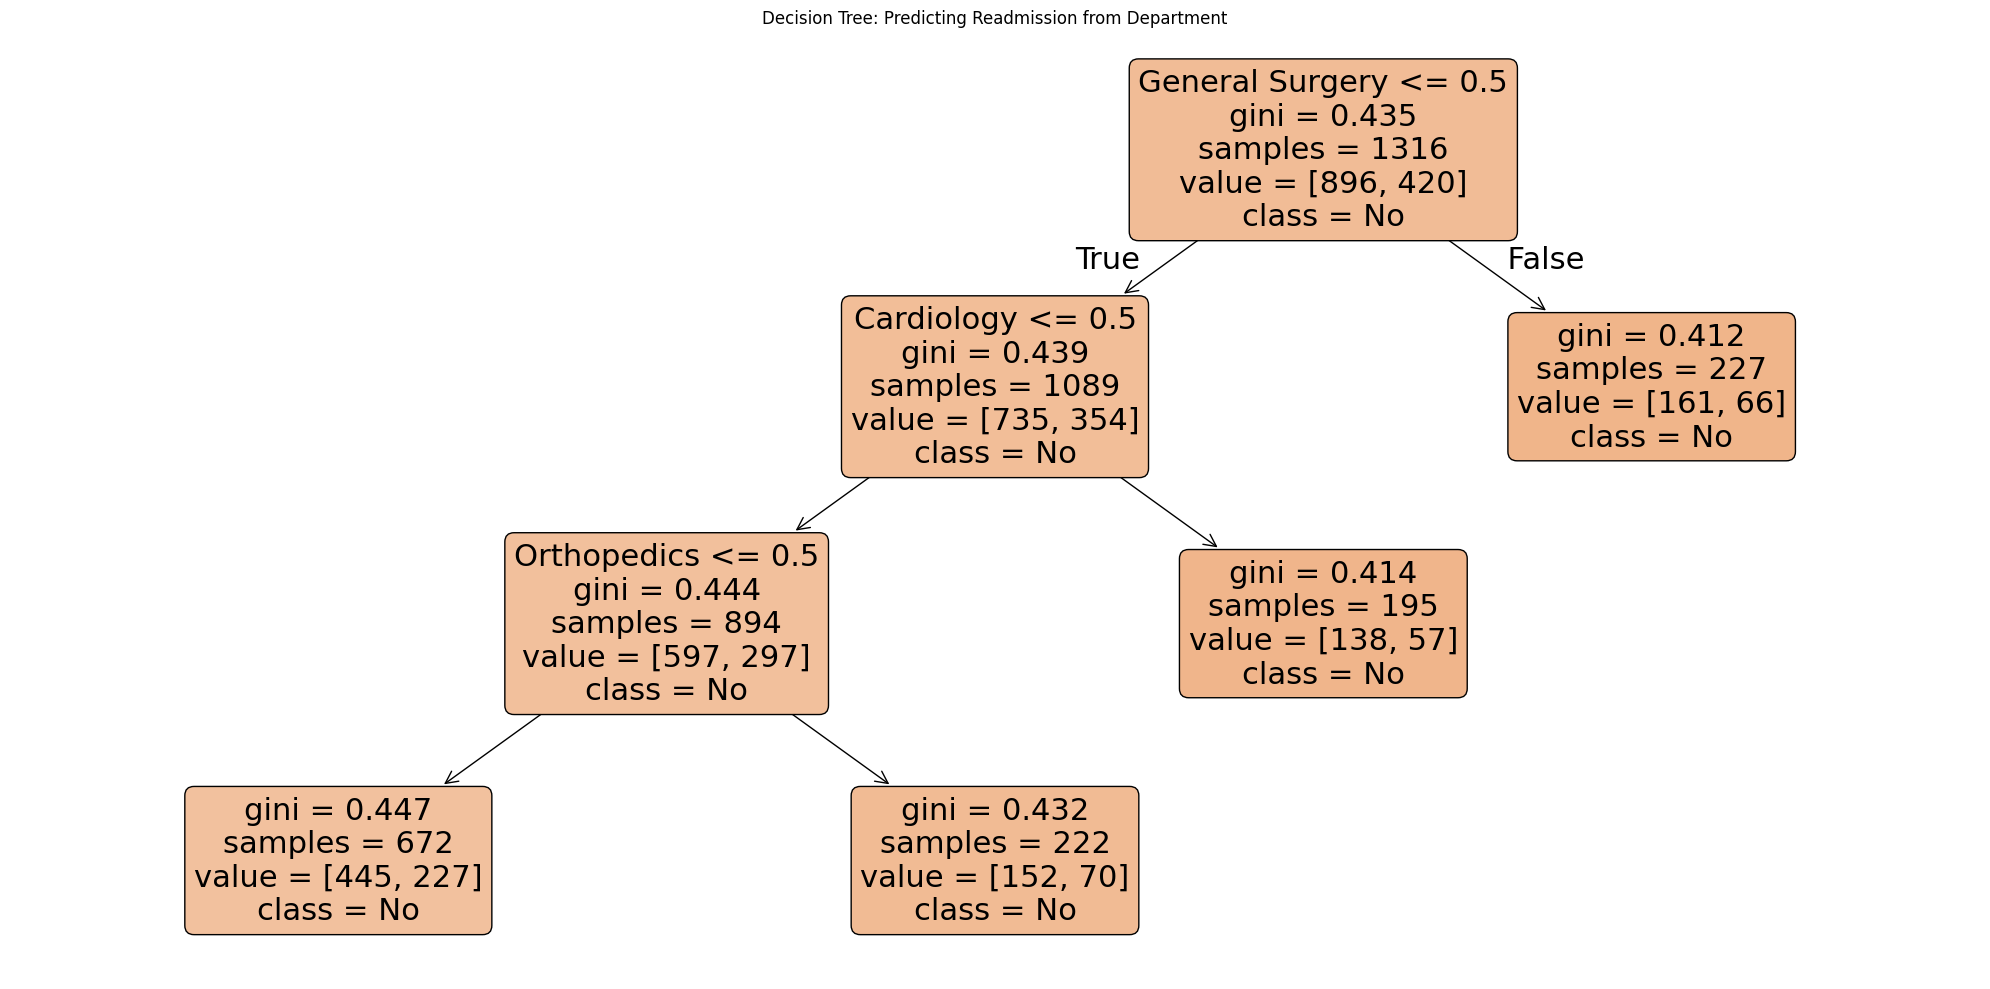

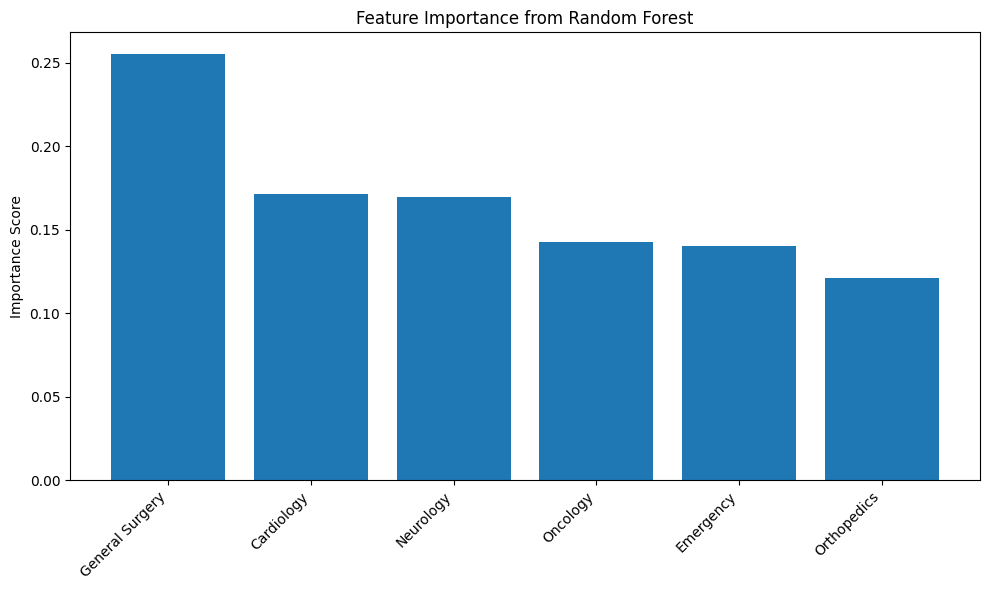

In [17]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

# One-hot encode the categorical department feature
onehot = OneHotEncoder()
X_dept = onehot.fit_transform(df[["Discharge Department"]]).toarray()
y_readmit = df["Readmitted"].values

# 1. Decision Tree visualization
dt_model = DecisionTreeClassifier(max_depth=3, random_state=0)
dt_model.fit(X_dept, y_readmit)

fig4, ax4 = plt.subplots(figsize=(20, 10))
plot_tree(dt_model,
          feature_names=onehot.categories_[0],
          class_names=["No", "Yes"],
          filled=True,
          rounded=True,
          ax=ax4)
ax4.set_title("Decision Tree: Predicting Readmission from Department")
plt.tight_layout()
plt.show()

# 2. Random Forest feature importance
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_dept, y_readmit)

importances = rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
features = np.array(onehot.categories_[0])[indices]

fig5, ax5 = plt.subplots(figsize=(10, 6))
ax5.bar(range(len(importances)), importances[indices], align='center')
ax5.set_xticks(range(len(importances)))
ax5.set_xticklabels(features, rotation=45, ha='right')
ax5.set_title("Feature Importance from Random Forest")
ax5.set_ylabel("Importance Score")
plt.tight_layout()
plt.show()

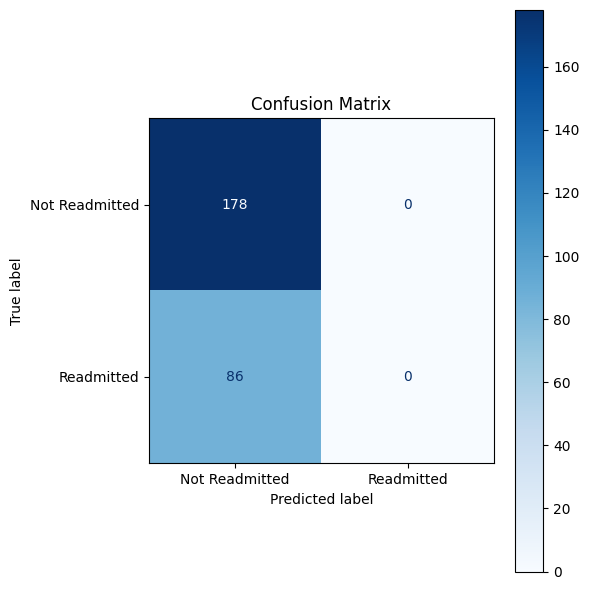

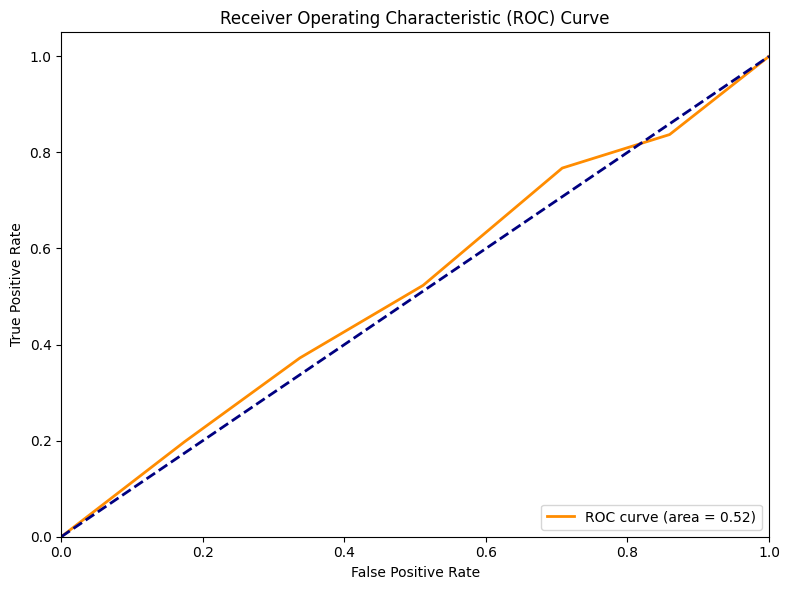

In [18]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
from sklearn.model_selection import train_test_split

# Split data for evaluation
X_train, X_test, y_train, y_test = train_test_split(X_dept, y_readmit, test_size=0.2, random_state=0)

# Fit a random forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)
y_prob = rf_model.predict_proba(X_test)[:, 1]

# 1. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
fig6, ax6 = plt.subplots(figsize=(6, 6))
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Not Readmitted", "Readmitted"]).plot(ax=ax6, cmap='Blues')
ax6.set_title("Confusion Matrix")
plt.tight_layout()
plt.show()

# 2. ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

fig7, ax7 = plt.subplots(figsize=(8, 6))
ax7.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
ax7.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
ax7.set_xlim([0.0, 1.0])
ax7.set_ylim([0.0, 1.05])
ax7.set_xlabel('False Positive Rate')
ax7.set_ylabel('True Positive Rate')
ax7.set_title('Receiver Operating Characteristic (ROC) Curve')
ax7.legend(loc="lower right")
plt.tight_layout()
plt.show()